In [4]:
import torch
import librosa
import os
import matplotlib.pyplot as plt
import csv
import pandas as pd

dataset_name = "e-gmd-v1.0.0"

df = pd.read_csv(os.path.join(dataset_name, "e-gmd-v1.0.0-clean.csv"))

train_dfs = []
valid_dfs = []

def process_row(row):
    onsets_path = row['csv_filename']
    onsets_df = pd.read_csv(os.path.join(dataset_name, onsets_path))
    onsets_df['audio_filename'] = row['audio_filename']
    split = row['split']
    if split == 'train':
        train_dfs.append(onsets_df)
    elif split == 'validation':
        valid_dfs.append(onsets_df)

df.apply(process_row, axis=1)

train_df = pd.concat(train_dfs, ignore_index=True)
valid_df = pd.concat(valid_dfs, ignore_index=True)

train_df

,pitches,velocities,start_time,end_time,audio_filename
0,38,7,2.115625,2.176563,drummer1/session1/1_funk_80_beat_4-4_1.wav
1,38,10,2.176563,2.215625,drummer1/session1/1_funk_80_beat_4-4_1.wav
2,38,56,2.454688,2.556250,drummer1/session1/1_funk_80_beat_4-4_1.wav
3,44,65,2.614063,2.715625,drummer1/session1/1_funk_80_beat_4-4_1.wav
4,38,48,2.628125,2.728125,drummer1/session1/1_funk_80_beat_4-4_1.wav
...,...,...,...,...,...
8579843,36,55,8.191250,8.291250,drummer9/session1/9_rock_100_beat_4-4_8.wav
8579844,36,43,8.311250,8.412500,drummer9/session1/9_rock_100_beat_4-4_8.wav
8579845,40,127,8.383750,8.483750,drummer9/session1/9_rock_100_beat_4-4_8.wav
8579846,36,65,8.660000,8.761250,drummer9/session1/9_rock_100_beat_4-4_8.wav


In [5]:
drum_mapping ={
        36: "kick",
        37: "snare_xstick",
        38: "snare",
        39: "clap",
        40: "snare_rimshot",

        48: "tom1",
        50: "tom1_rim",
        45: "tom2",
        47: "tom2_rim",
        43: "tom3",
        58: "tom3_rim",

        46: "hhopen_bow",
        #26: "hhopen_edge",
        42: "hhclosed_bow",
        #22: "hhclosed_edge",
        44: "hhpedal",
        54: "tambourine",
          
        49: "crash1_bow",
        55: "crash1_edge",
        57: "crash2_bow",
        52: "crash2_edge",

        51: "ride_bow",
        59: "ride_edge",
          
        53: "ride_bell",
        56: "cowbell",
}

In [41]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np
from IPython.display import Audio
import time

# Define the dataset class
class DrumDataset(Dataset):
    def __init__(self, df, transform, sr=44100, window_size=8192):
        self.df = df
        self.window_size = window_size
        self.transform = transform
        self.sr = sr
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load the onset time, label, and track name for the given index
        row = self.df.iloc[idx]
        #onset_time = (row['start_time']+row['end_time'])/2 # middle of note variant
        onset_time = row['start_time'] # start of note variant
        track_filename = row['audio_filename']
        audio, sr = torchaudio.load(os.path.join(dataset_name, track_filename), frame_offset=int(onset_time*self.sr)-self.window_size//2, num_frames=self.window_size)
        onset_window = audio
        if onset_window.shape[0] == 2:
            onset_window = torch.mean(onset_window, dim=0, keepdim=True)
        padding_size = max(0, self.window_size - onset_window.size(-1))

        if padding_size > 0:
            padding = (padding_size // 2, padding_size - padding_size // 2)  # divide the padding equally before and after the window
            onset_window = torch.nn.functional.pad(onset_window, padding, "constant", 0)

        # Create binary mask for overlapping drum notes
        drum_tensor = torch.zeros(len(drum_mapping))
        if isinstance(row['pitches'], str):
            for pitch in row['pitches'].split(" "):
                index = list(drum_mapping.keys()).index(int(pitch))
                drum_tensor[index] = 1
        else:
            index = list(drum_mapping.keys()).index(int(row['pitches']))
            drum_tensor[index] = 1
        spec = self.transform(onset_window[0])
        return spec, drum_tensor, Audio(onset_window, rate=self.sr)

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to("cuda")),
    # transforms.RandomApply([
    #     torchaudio.transforms.PitchShift(sample_rate=44100, n_steps=random.uniform(-1, 1)),
    #     torchaudio.transforms.TimeStretch(hop_length=64, fixed_rate=random.uniform(0.8, 1.2)),
    # ], p=0.5),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=2048,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
    torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': 2048, 'hop_length': 64, 'n_mels': 128}).to("cuda")(x)
            ], dim=0).to("cuda")),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    transforms.Lambda(lambda x: x.to("cpu"))
])

valid_dataset = DrumDataset(valid_df, transform)
train_dataset = DrumDataset(train_df, transform)

In [89]:
rand = random.randint(1, len(train_df))
row = train_dataset.df.iloc[4451457]
window_size = 8192
audio, sr = librosa.load(os.path.join(dataset_name, row['audio_filename']))
onset_time = row['start_time']
onset_window = audio[int(onset_time*sr)-window_size//2:int(onset_time*sr)+window_size//2]
onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(audio))
print(rand, row['pitches'])
Audio((audio+clicks)[int(onset_time*sr)-window_size//2:int(onset_time*sr)+window_size//2], rate=sr)

6419732 44


5081928 ['hhpedal']


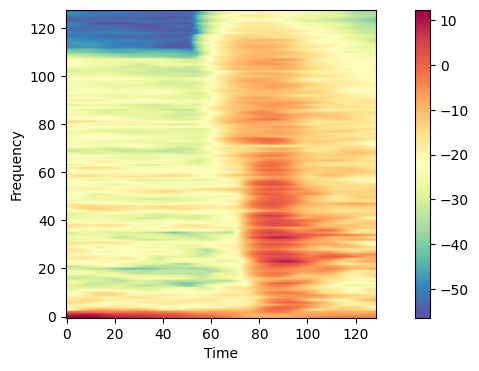

In [107]:
rand = random.randint(1, len(train_df))
a, x, audio = train_dataset.__getitem__(rand)
drum_notes = []
for i, val in enumerate(x):
    if val == 1:
        drum_note = list(drum_mapping.values())[i]
        if drum_note:
            drum_notes.append(drum_note)
specgram = a[0].squeeze(0).numpy()
print(rand, drum_notes)

# Display the spectrogram using matplotlib
plt.figure(figsize=(10, 4))
plt.imshow(specgram, cmap='Spectral_r', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
audio
#drummer7/session3/39_rock-indie_63_beat_4-4_12.wav
#7874786, 4065736

In [14]:
# Define the neural network architecture
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

# Hyperparameters
fraction = 0.001
n_epochs = 200
learning_rate = 0.001
batch_size = 512

class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(256, len(drum_mapping))
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

class DynamicSubsetRandomSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, fraction):
        self.data_source = data_source
        self.fraction = fraction

    def __iter__(self):
        indices = list(range(len(self.data_source)))
        np.random.shuffle(indices)
        subset_indices = indices[:int(self.fraction * len(indices))]
        return iter(subset_indices)

    def __len__(self):
        return int(self.fraction * len(self.data_source))

x = x.view(x.size(0), -1)

def accuracy(outputs, labels, threshold=0.5):
    with torch.no_grad():
        preds = (outputs > threshold).float()
        correct = (preds == labels).sum(dim=1).eq(labels.shape[1]).sum().item()
        total = labels.shape[0]
        return 100 * correct / total



# Initialize the neural network and optimizer
device = torch.device('cuda')
model = DrumCNN().to(device)
#model.load_state_dict(torch.load('model_checkpoint.pth'))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

# Define the loss function
criterion = nn.CrossEntropyLoss().cuda()

# Train the model
for epoch in range(n_epochs):
    # Create random data loaders for training and validation sets
    train_subset_sampler = DynamicSubsetRandomSampler(train_dataset, fraction)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subset_sampler)
    valid_subset_sampler = DynamicSubsetRandomSampler(valid_dataset, fraction)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_subset_sampler)

    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=len(train_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_acc += accuracy(outputs, labels) * inputs.size(0)
    train_loss /= int(fraction * len(train_loader.dataset))
    train_acc /= int(fraction * len(train_loader.dataset))
    
    # Evaluate the model on the validation set
    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(valid_loader, total=len(valid_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Validation")):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_acc += accuracy(outputs, labels) * inputs.size(0)
            true_labels.extend(labels.cpu().numpy().tolist())
            predicted_labels.extend((outputs.cpu() > 0.5).float().numpy().tolist())
        valid_loss /= int(fraction * len(valid_loader.dataset))
        valid_acc /= int(fraction * len(valid_loader.dataset))
        cm = multilabel_confusion_matrix(true_labels, predicted_labels)
        f, axes = plt.subplots(5, 5, figsize=(25, 25))
        axes = axes.ravel()
        for i in range(23):
            disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
            disp.plot(ax=axes[i], values_format='.4g')
            disp.ax_.set_title(list(drum_mapping.values())[i])
            if i<10:
                disp.ax_.set_xlabel('pred')
            if i%5!=0:
                disp.ax_.set_ylabel('true')
            disp.im_.colorbar.remove()

        plt.subplots_adjust(wspace=0.10, hspace=0.1)
        f.colorbar(disp.im_, ax=axes)
        plt.savefig(f'cm_e{epoch+1}.png')
        plt.close()
    
    # Update the learning rate based on the validation loss
    scheduler.step(valid_loss)
    
    # Print the training and validation loss and accuracy
    tqdm.write(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%\n', end='\r')

Epoch 1/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.09s/batch]


Train Loss: 3.3845, Train Acc: 26.18%, Valid Loss: 3.2179, Valid Acc: 40.24%


Epoch 2/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.13s/batch]


Train Loss: 3.1675, Train Acc: 44.15%, Valid Loss: 3.2123, Valid Acc: 40.01%


Epoch 3/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.15s/batch]


Train Loss: 3.1511, Train Acc: 45.73%, Valid Loss: 3.1337, Valid Acc: 44.84%


Epoch 4/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.09s/batch]


Train Loss: 3.1755, Train Acc: 45.80%, Valid Loss: 3.1133, Valid Acc: 49.89%


Epoch 5/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.03s/batch]


Train Loss: 3.1619, Train Acc: 46.49%, Valid Loss: 3.1330, Valid Acc: 46.77%


Epoch 6/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.17s/batch]


Train Loss: 3.1403, Train Acc: 47.38%, Valid Loss: 3.1386, Valid Acc: 46.92%


Epoch 7/200 Validation: 100%|██████████| 3/3 [00:14<00:00,  4.82s/batch]


Train Loss: 3.1472, Train Acc: 47.97%, Valid Loss: 3.0471, Valid Acc: 50.26%


Epoch 8/200 Validation: 100%|██████████| 3/3 [00:13<00:00,  4.49s/batch]


Train Loss: 3.1685, Train Acc: 47.36%, Valid Loss: 3.0629, Valid Acc: 48.78%


Epoch 9/200 Validation: 100%|██████████| 3/3 [00:16<00:00,  5.38s/batch]


Train Loss: 3.1453, Train Acc: 48.16%, Valid Loss: 3.0507, Valid Acc: 51.82%


Epoch 10/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.07s/batch]


Train Loss: 3.1118, Train Acc: 49.36%, Valid Loss: 3.0944, Valid Acc: 48.48%


Epoch 11/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.22s/batch]


Train Loss: 3.1098, Train Acc: 49.63%, Valid Loss: 3.0627, Valid Acc: 50.71%


Epoch 12/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.17s/batch]


Train Loss: 3.1203, Train Acc: 50.38%, Valid Loss: 3.0737, Valid Acc: 50.85%


Epoch 13/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.11s/batch]


Train Loss: 3.1094, Train Acc: 50.71%, Valid Loss: 3.0962, Valid Acc: 50.33%


Epoch 14/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.06s/batch]


Train Loss: 3.0994, Train Acc: 52.44%, Valid Loss: 3.1103, Valid Acc: 50.04%


Epoch 15/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.22s/batch]


Train Loss: 3.0936, Train Acc: 51.72%, Valid Loss: 3.0825, Valid Acc: 50.71%


Epoch 16/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.01s/batch]


Train Loss: 3.1193, Train Acc: 52.07%, Valid Loss: 3.0486, Valid Acc: 52.26%


Epoch 17/200 Validation: 100%|██████████| 3/3 [00:15<00:00,  5.09s/batch]


Train Loss: 3.1146, Train Acc: 50.87%, Valid Loss: 3.0743, Valid Acc: 51.22%


Epoch 18/200 Training:  47%|████▋     | 8/17 [01:00<01:07,  7.50s/batch]


KeyboardInterrupt: 

In [296]:
torch.save(model.state_dict(), f'{dataset_name}_{fraction}_{valid_acc}.pth')